---
## Dataset Loading and Exploratory Data Analysis

The dataset is explored to understand image counts, class distribution, and sample visualizations. Image sizes are checked to confirm consistency, and class balance is analyzed to identify potential imbalances. Visualizations include sample images per class and a bar plot of class distribution, fulfilling the EDA requirements.

---

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"yasamanamoujafary","key":"567d729b455e97b155b34537fcd1ea77"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d alsaniipe/flowers-multiclass-datasets
!unzip flowers-multiclass-datasets.zip -d flowers

Dataset URL: https://www.kaggle.com/datasets/alsaniipe/flowers-multiclass-datasets
License(s): apache-2.0
flowers-multiclass-datasets.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  flowers-multiclass-datasets.zip
replace flowers/flowers/flowers/flower_photos/test/daisy/10172379554_b296050f82_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: flowers/flowers/flowers/flower_photos/test/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/flowers/flowers/flower_photos/test/daisy/1306119996_ab8ae14d72_n.jpg  
  inflating: flowers/flowers/flowers/flower_photos/test/daisy/134409839_71069a95d1_m.jpg  
  inflating: flowers/flowers/flowers/flower_photos/test/daisy/19813618946_93818db7aa_m.jpg  
  inflating: flowers/flowers/flowers/flower_photos/test/daisy/3338077096_3a8ed0e2bc_m.jpg  
  inflating: flowers/flowers/flowers/flower_photos/test/daisy/3552074420_2a0a7166db_m.jpg  
  inflating: flowers/flowers/flowers/flower_photos/test/d

Train set image counts: {'daisy': 607, 'dandelion': 872, 'roses': 615, 'sunflowers': 673, 'tulips': 773}
Validation set image counts: {'daisy': 16, 'dandelion': 16, 'roses': 16, 'sunflowers': 16, 'tulips': 16}
Test set image counts: {'daisy': 10, 'dandelion': 10, 'roses': 10, 'sunflowers': 10, 'tulips': 10}


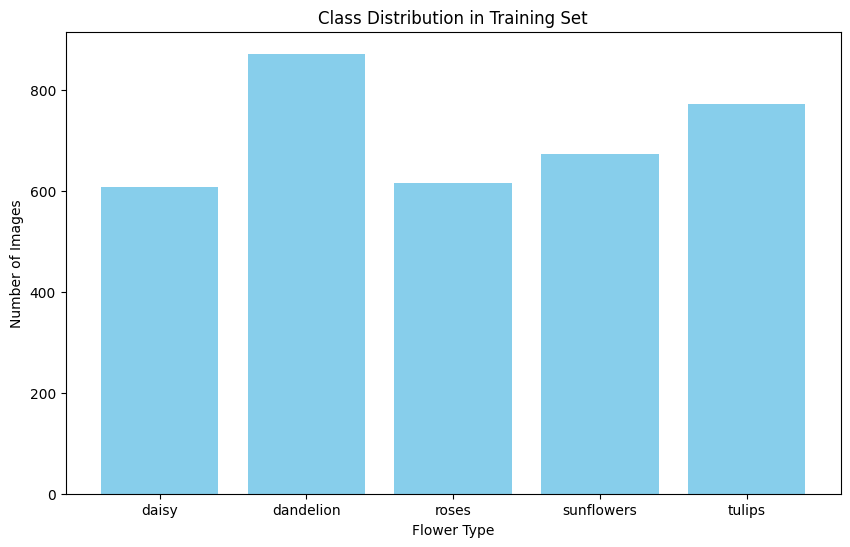

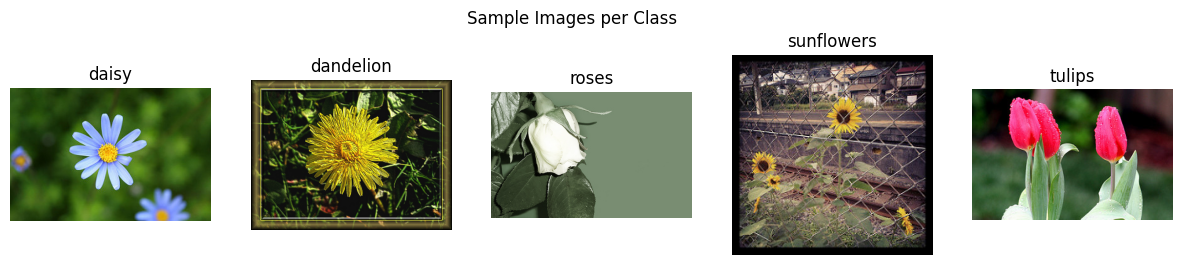

Sample image sizes: [(320, 213), (500, 375), (500, 314), (240, 240), (320, 209)]


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter

# (Optional) For inline plotting in Colab
%matplotlib inline

# Define dataset paths
data_dir = 'flowers/flowers/flowers/flower_photos'
splits = ['train', 'validation', 'test']
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Count images per class and split
image_counts = {split: Counter() for split in splits}
for split in splits:
    for cls in classes:
        cls_path = os.path.join(data_dir, split, cls)
        image_counts[split][cls] = len(os.listdir(cls_path))
    print(f"{split.capitalize()} set image counts:", dict(image_counts[split]))

# Visualize class distribution
plt.figure(figsize=(10, 6))
train_counts = [image_counts['train'][cls] for cls in classes]
plt.bar(classes, train_counts, color='skyblue')
plt.title('Class Distribution in Training Set')
plt.xlabel('Flower Type')
plt.ylabel('Number of Images')
plt.show()

# Check image sizes and display samples
fig, axes = plt.subplots(1, len(classes), figsize=(15, 3))
sizes = []
for i, cls in enumerate(classes):
    img_path = os.path.join(data_dir, 'train', cls, os.listdir(os.path.join(data_dir, 'train', cls))[0])
    img = Image.open(img_path)
    sizes.append(img.size)
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis('off')
plt.suptitle('Sample Images per Class')
plt.show()
print("Sample image sizes:", sizes)


---
## Data Preprocessing and Augmentation
This section preprocesses the dataset by resizing images to 224x224 (standard for VGG/ResNet), normalizing pixel values using ImageNet means and standard deviations, and applying data augmentation to the training set (random rotations, flips, crops, brightness/contrast changes) to improve generalization. PyTorch’s `DataLoader` is used to create batches (size 32) for training, validation, and test sets, ensuring efficient data loading.

---

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Dataset sizes: Train={len(train_dataset)}, Validation={len(val_dataset)}, Test={len(test_dataset)}")
print(f"Class indices:", train_dataset.class_to_idx)


Using device: cuda
Dataset sizes: Train=3540, Validation=80, Test=50
Class indices: {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


---
## VGG CNN from Scratch
This section defines and trains a VGG-style CNN with stacked 3x3 convolutional layers, max-pooling, and fully connected layers. The model has three convolutional blocks (64, 128, 256 filters) followed by two dense layers (512 units) and a 5-unit output layer for classification. It is trained for 20 epochs using CrossEntropyLoss, Adam optimizer (lr=0.001), and early stopping to prevent overfitting. Validation performance is monitored, and loss/accuracy plots are generated.

---

In [7]:
print("Training on device:", device)

Training on device: cuda


Epoch [1/20], Train Loss: 1.4994, Val Loss: 1.3532, Val Accuracy: 45.00%
Epoch [2/20], Train Loss: 1.2421, Val Loss: 1.1227, Val Accuracy: 62.50%
Epoch [3/20], Train Loss: 1.1234, Val Loss: 0.9595, Val Accuracy: 62.50%
Epoch [4/20], Train Loss: 1.0573, Val Loss: 0.9081, Val Accuracy: 71.25%
Epoch [5/20], Train Loss: 1.0364, Val Loss: 0.9131, Val Accuracy: 63.75%
Epoch [6/20], Train Loss: 1.0006, Val Loss: 0.8172, Val Accuracy: 77.50%
Epoch [7/20], Train Loss: 0.9911, Val Loss: 0.8783, Val Accuracy: 73.75%
Epoch [8/20], Train Loss: 0.9649, Val Loss: 0.9481, Val Accuracy: 68.75%
Epoch [9/20], Train Loss: 0.9580, Val Loss: 0.9495, Val Accuracy: 75.00%
Epoch [10/20], Train Loss: 0.9388, Val Loss: 0.8563, Val Accuracy: 71.25%
Epoch [11/20], Train Loss: 0.9479, Val Loss: 0.8899, Val Accuracy: 68.75%
Early stopping triggered


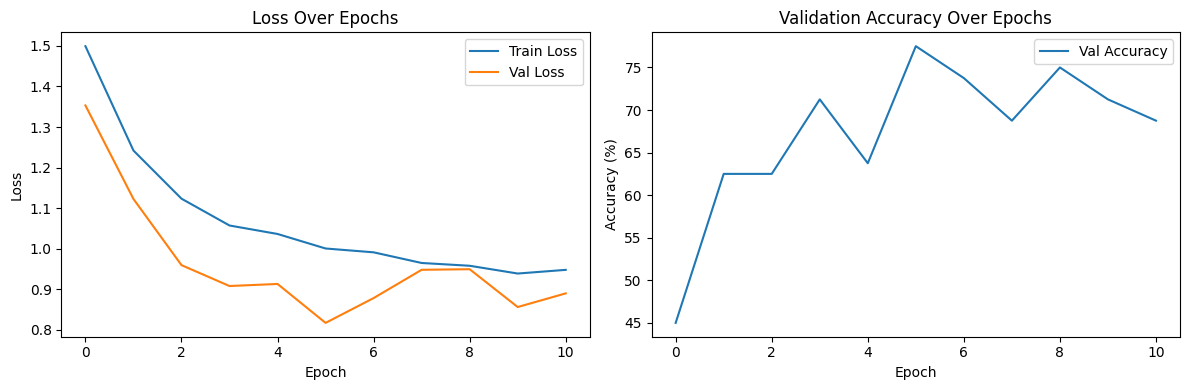

VGG training completed


In [9]:
import torch.nn as nn
import torch.optim as optim

# Define VGG-style CNN
class VGGCustom(nn.Module):
    def __init__(self, num_classes=5):
        super(VGGCustom, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 28 * 28, 512), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(512, 512), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5, device='cpu'):
    model = model.to(device)
    train_losses, val_losses, val_accuracies = [], [], []
    best_val_loss, patience_counter = float('inf'), 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'vgg_best.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return model

# ✅ Initialize and train model on GPU
vgg_model = VGGCustom(num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=0.001)

# Make sure to pass device here
vgg_model = train_model(vgg_model, train_loader, val_loader, criterion, optimizer, device=device)
print("VGG training completed")


---
## Fine-Tuning Pretrained ResNet50
This section fine-tunes a pretrained ResNet50 in three stages: (1) freeze convolutional layers and train a new classifier (10 epochs), (2) unfreeze the last convolutional block (layer4) and train with the classifier (10 epochs), and (3) unfreeze all layers and train the entire network (10 epochs). Each stage uses CrossEntropyLoss, Adam optimizer (lr=0.001 for stage 1, 0.0001 for stages 2-3), and early stopping. Validation performance is monitored, and loss/accuracy plots are generated for each stage.

---

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


[Stage 1] Epoch 1/10 | Train Loss: 0.7970 | Val Loss: 0.5408 | Val Acc: 80.00%
[Stage 1] Epoch 2/10 | Train Loss: 0.4525 | Val Loss: 0.5844 | Val Acc: 78.75%
[Stage 1] Epoch 3/10 | Train Loss: 0.4138 | Val Loss: 0.4485 | Val Acc: 81.25%
[Stage 1] Epoch 4/10 | Train Loss: 0.3644 | Val Loss: 0.4859 | Val Acc: 83.75%
[Stage 1] Epoch 5/10 | Train Loss: 0.3542 | Val Loss: 0.4476 | Val Acc: 82.50%
[Stage 1] Epoch 6/10 | Train Loss: 0.3328 | Val Loss: 0.5644 | Val Acc: 81.25%
[Stage 1] Epoch 7/10 | Train Loss: 0.3396 | Val Loss: 0.4646 | Val Acc: 83.75%
[Stage 1] Epoch 8/10 | Train Loss: 0.3165 | Val Loss: 0.4583 | Val Acc: 82.50%
[Stage 1] Epoch 9/10 | Train Loss: 0.3053 | Val Loss: 0.3737 | Val Acc: 88.75%
[Stage 1] Epoch 10/10 | Train Loss: 0.3040 | Val Loss: 0.4074 | Val Acc: 86.25%


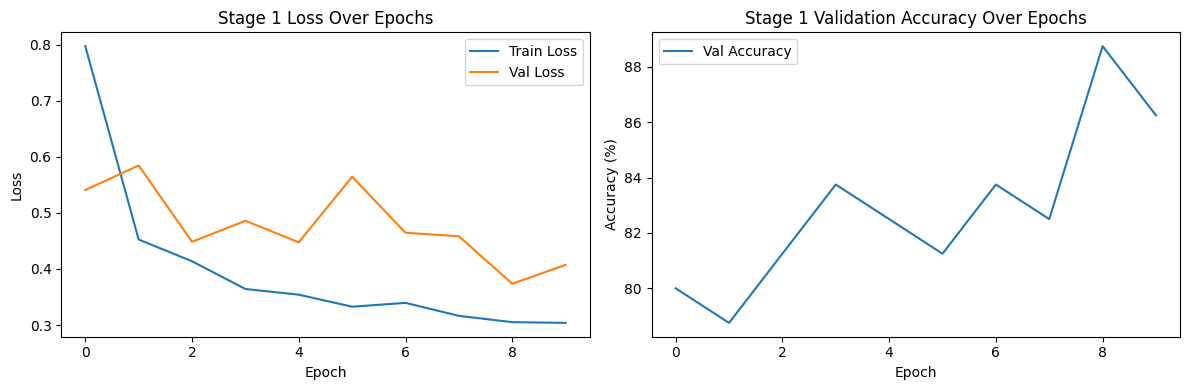

[Stage 2] Epoch 1/10 | Train Loss: 0.3130 | Val Loss: 0.1872 | Val Acc: 92.50%
[Stage 2] Epoch 2/10 | Train Loss: 0.1560 | Val Loss: 0.2444 | Val Acc: 88.75%
[Stage 2] Epoch 3/10 | Train Loss: 0.1110 | Val Loss: 0.3672 | Val Acc: 92.50%
[Stage 2] Epoch 4/10 | Train Loss: 0.0895 | Val Loss: 0.2823 | Val Acc: 92.50%
[Stage 2] Epoch 5/10 | Train Loss: 0.0929 | Val Loss: 0.3122 | Val Acc: 92.50%
[Stage 2] Epoch 6/10 | Train Loss: 0.0579 | Val Loss: 0.3070 | Val Acc: 90.00%
[Stage 2] Early stopping triggered at epoch 6


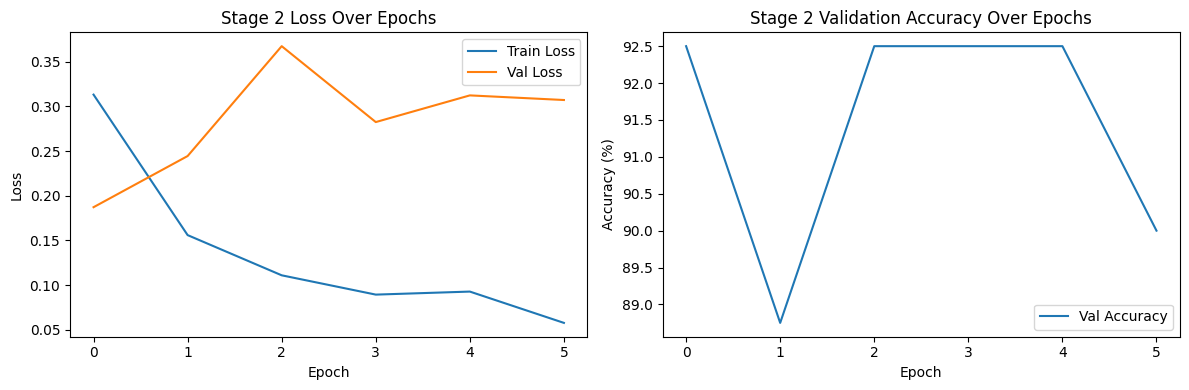

[Stage 3] Epoch 1/10 | Train Loss: 0.2222 | Val Loss: 0.2078 | Val Acc: 90.00%
[Stage 3] Epoch 2/10 | Train Loss: 0.1464 | Val Loss: 0.1664 | Val Acc: 91.25%
[Stage 3] Epoch 3/10 | Train Loss: 0.1164 | Val Loss: 0.2370 | Val Acc: 93.75%
[Stage 3] Epoch 4/10 | Train Loss: 0.0865 | Val Loss: 0.2960 | Val Acc: 91.25%
[Stage 3] Epoch 5/10 | Train Loss: 0.0492 | Val Loss: 0.1468 | Val Acc: 96.25%
[Stage 3] Epoch 6/10 | Train Loss: 0.0568 | Val Loss: 0.2176 | Val Acc: 91.25%
[Stage 3] Epoch 7/10 | Train Loss: 0.0555 | Val Loss: 0.0713 | Val Acc: 97.50%
[Stage 3] Epoch 8/10 | Train Loss: 0.0571 | Val Loss: 0.2559 | Val Acc: 95.00%
[Stage 3] Epoch 9/10 | Train Loss: 0.0493 | Val Loss: 0.2520 | Val Acc: 95.00%
[Stage 3] Epoch 10/10 | Train Loss: 0.0774 | Val Loss: 0.0906 | Val Acc: 95.00%


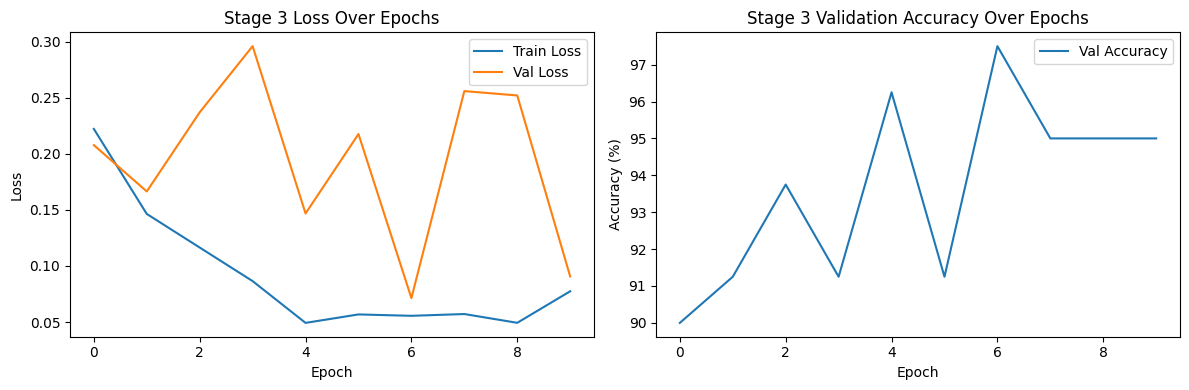

✅ ResNet fine-tuning completed.


In [10]:
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ✅ Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ✅ Fine-tuning function
def fine_tune_resnet(stage, model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5, device='cpu'):
    model = model.to(device)
    train_losses, val_losses, val_accuracies = [], [], []
    best_val_loss, patience_counter = float('inf'), 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"[Stage {stage}] Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'resnet_stage_{stage}_best.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"[Stage {stage}] Early stopping triggered at epoch {epoch+1}")
                break

    # Plot history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'Stage {stage} Loss Over Epochs')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title(f'Stage {stage} Validation Accuracy Over Epochs')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend()
    plt.tight_layout()
    plt.show()
    return model
# Load pretrained ResNet50
resnet_model = models.resnet50(pretrained=True)
num_classes = 5

# Stage 1: Freeze base, train head
for param in resnet_model.parameters():
    param.requires_grad = False
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)
resnet_model = fine_tune_resnet(1, resnet_model, train_loader, val_loader, criterion, optimizer, device=device)

# Stage 2: Unfreeze layer4
resnet_model.load_state_dict(torch.load('resnet_stage_1_best.pth', map_location=device))
for param in resnet_model.layer4.parameters():
    param.requires_grad = True
optimizer = optim.Adam([
    {'params': resnet_model.layer4.parameters()},
    {'params': resnet_model.fc.parameters()}
], lr=0.0001)
resnet_model = fine_tune_resnet(2, resnet_model, train_loader, val_loader, criterion, optimizer, device=device)

# Stage 3: Unfreeze all layers
resnet_model.load_state_dict(torch.load('resnet_stage_2_best.pth', map_location=device))
for param in resnet_model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)
resnet_model = fine_tune_resnet(3, resnet_model, train_loader, val_loader, criterion, optimizer, device=device)

print("✅ ResNet fine-tuning completed.")


---
## Result Comparison
This section evaluates the VGG and ResNet models on the test set, computing accuracy, precision, recall, and F1-score. Confusion matrices and ROC curves (with AUC scores) are plotted to compare model performance. The ResNet model from stage 3 is used, as it typically performs best. Results are analyzed to discuss trade-offs between training from scratch (VGG) and transfer learning (ResNet).

---

Using device: cuda
GPU: Tesla T4 | CUDA version: 12.4


<ipython-input-11-224824447fbd>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



📊 VGG Metrics:
Accuracy:  0.6200
Precision: 0.6045
Recall:    0.6200
F1-Score:  0.6001


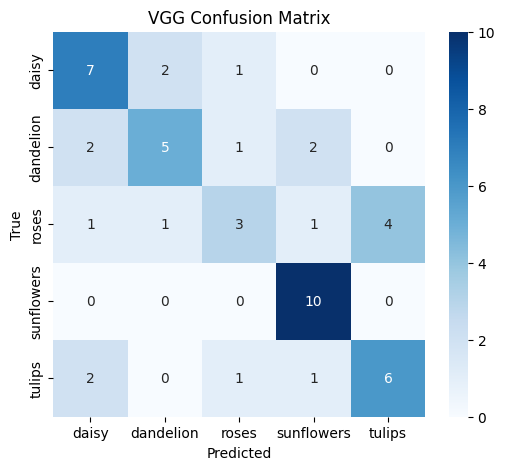

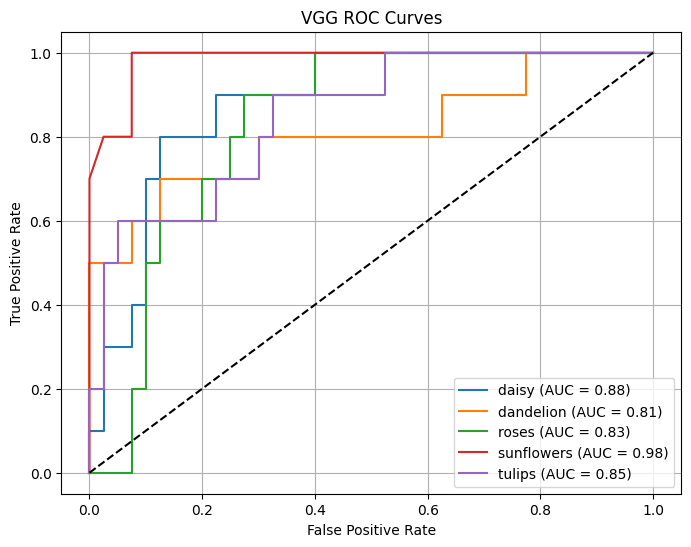

<ipython-input-11-224824447fbd>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



📊 ResNet Metrics:
Accuracy:  0.8600
Precision: 0.8623
Recall:    0.8600
F1-Score:  0.8584


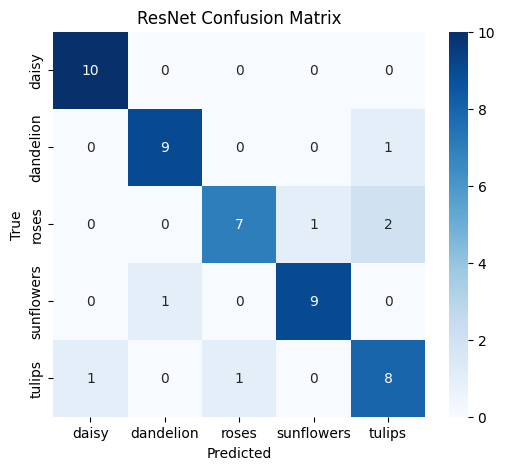

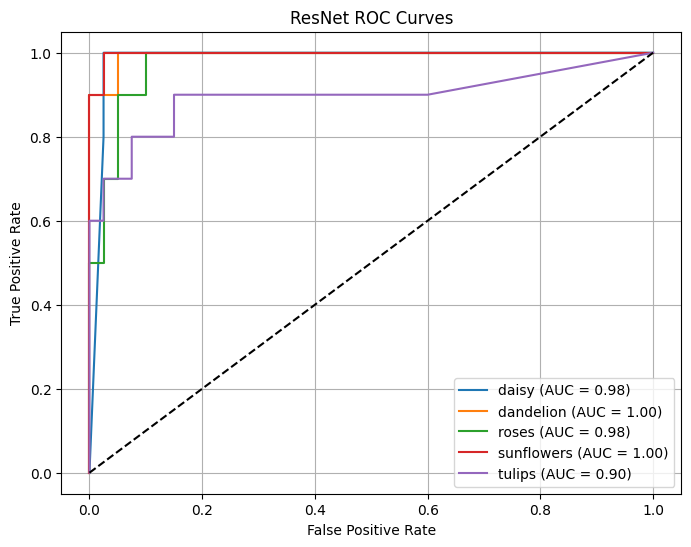


📌 Analysis:
- VGG was trained from scratch; it may underperform with limited data.
- ResNet benefits from transfer learning; generally achieves better performance.
- ROC & AUC help compare per-class confidence and separability.


In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from torch.cuda.amp import autocast

# ✅ VGGCustom model class
class VGGCustom(nn.Module):
    def __init__(self, num_classes=5):
        super(VGGCustom, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 28 * 28, 512), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(512, 512), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ✅ Evaluation function
def evaluate_model(model, test_loader, model_name, classes, device):
    model = model.to(device)
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f"\n📊 {model_name} Metrics:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()

    # ROC & AUC
    y_bin = label_binarize(all_labels, classes=list(range(len(classes))))
    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_bin[:, i], np.array(all_probs)[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{model_name} ROC Curves')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# ✅ Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)} | CUDA version: {torch.version.cuda}")

# ✅ Get class labels
classes = train_dataset.classes

# ✅ Load VGG model
vgg_model = VGGCustom(num_classes=5).to(device)
vgg_model.load_state_dict(torch.load('vgg_best.pth', map_location=device))

# ✅ Load ResNet model
resnet_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 5)
resnet_model.load_state_dict(torch.load('resnet_stage_3_best.pth', map_location=device))

# ✅ Evaluate
evaluate_model(vgg_model, test_loader, 'VGG', classes, device)
evaluate_model(resnet_model, test_loader, 'ResNet', classes, device)

# ✅ Analysis Summary
print("\n📌 Analysis:")
print("- VGG was trained from scratch; it may underperform with limited data.")
print("- ResNet benefits from transfer learning; generally achieves better performance.")
print("- ROC & AUC help compare per-class confidence and separability.")
